## Setup: Installing prerequisites

In [1]:
!pip install -q matplotlib numpy scipy tqdm

In [2]:
!pip install -qU git+https://github.com/norse/norse

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Integrating point neuron model equations

Spiking neuron models given as (typically very simple) systems of ordinary differential
equations,
\begin{align*}
\dot{v} &= -(v - v_\text{reset}) + I \\
\dot{I} &= -I + I_\text{in}
\end{align*}
together with jump and transition equations, that specify when a jump occurs and
how the state variables change. A prototypical equation is a leaky integrator
with constant current input $I_\text{in}$, with jump condition $v - 1 = 0$ and transition equation $v^+ - v^- = -1$.


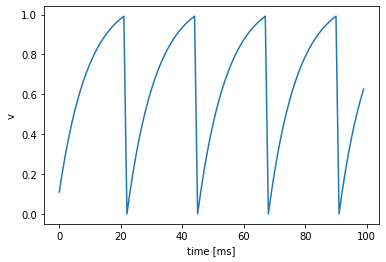

In [4]:
from norse.torch.functional.lif import lif_step, lif_feed_forward_step, lif_current_encoder, LIFParameters

NEURONS = 1 # number of neurons to consider
TIMESTEPS = 100 # number of timesteps to integrate

parameters = LIFParameters()
membrane_voltage = torch.zeros(NEURONS) # initial membrane voltage
input_current = 1.1 * torch.ones(NEURONS)

voltages = []

for _ in range(TIMESTEPS):
  spikes, membrane_voltage = lif_current_encoder(input_current, membrane_voltage, parameters)
  voltages.append(membrane_voltage)

voltages = torch.stack(voltages)

plt.ylabel("v")
plt.xlabel("time [ms]")
plt.plot(voltages)
plt.show()

## MNIST dataset

In [5]:
import torchvision

BATCH_SIZE = 32

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=True,
        download=True,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE
)

## Defining a Network

One of the distinguishing features of spiking neural networks is that they
operate on temporal data encoded as spikes. Common datasets in machine learning
of course don't use such an encoding and therefore make a encoding step necessary. Here we choose to treat the grayscale value of an MNIST image
as a constant current to produce input spikes to the rest of the network.
Another option would be to interpret the grayscale value as a spike probabilty
at each timestep.


In [6]:
from norse.torch.module.lif import LIFConstantCurrentEncoder

class Encoder(torch.nn.Module):
    def __init__(self, seq_length, device):
        super(Encoder, self).__init__()
        self.constant_current_encoder = LIFConstantCurrentEncoder(
            seq_length=seq_length, device=device
        )

    def forward(self, x):
        _, x = self.constant_current_encoder(x)
        return x

Once the data is encoded into spikes, a spiking neural network can be constructed in the same way as a one would construct a recurrent neural network.
Here we define a spiking neural network with one recurrently connected layer
with `hidden_features` LIF neurons and a readout layer with `output_features` and leaky-integrators. As you can see, we can freely combine spiking neural network primitives with ordinary `torch.nn.Module` layers.

In [7]:
from norse.torch.module.lif import LIFCell, LIFParameters, LIFFeedForwardCell
from norse.torch.module.leaky_integrator import LIFeedForwardCell

class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super(SNN, self).__init__()
        self.l1 = LIFCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100)                        
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LIFeedForwardCell(shape=(output_features,))

        
    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = self.l1.initial_state(batch_size, x.device, torch.float)
        so = self.out.initial_state(batch_size, x.device)
        voltages = []

        for ts in range(seq_length):
            # z is the output after non-linearity (in our case spikes)
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1) # overriding spikes (z) and state (s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            voltages += [vo]

        return torch.stack(voltages)

The output of the network we have defined are $10$ membrane voltage traces. What remains to do is to interpret those as a probabilty distribution. One way of doing so is to determine the maximum along the time dimension and to then compute the softmax of these values. There are other options of course, for example to consider
the average membrane voltage in a given time window or use a LIF neuron output layer and consider the time to first spike.

In [8]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

The final model is then simply the sequential composition of these three steps: Encoding, a spiking neural network and decoding.

In [9]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

We can then instantiate the model with the recurrent ```SNN``` network defined above.

In [10]:
T = 200
DEVICE = torch.device("cuda")
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

model = Model(
    encoder=Encoder(
      device=DEVICE,
      seq_length=T,
    ),
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): Encoder(
    (constant_current_encoder): LIFConstantCurrentEncoder()
  )
  (snn): SNN(
    (l1): LIFCell(784, 100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LIFeedForwardCell()
  )
)

What remains to do is to setup training and test code. This code is completely independent of the fact that we are training a spiking neural network and in fact has been largely copied from the pytorch tutorials.

In [11]:
from tqdm import tqdm

LOG_INTERVAL = 10
EPOCHS = 10

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=True, position=0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

Just like the training function, the test function is standard boilerplate, common with any other supervised learning task.

In [12]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

As is the the outer training loop.

In [13]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)       
    print(f"epoch: {epoch}, mean_loss: {mean_loss}, test_loss: {test_loss}, accuracy: {accuracy}", flush=True)

100%|██████████| 1875/1875 [07:43<00:00,  4.05it/s]


epoch: 0, mean_loss: 0.3629160894592603, test_loss: 0.21168936722278595, accuracy: 93.37


100%|██████████| 1875/1875 [07:33<00:00,  4.13it/s]


epoch: 1, mean_loss: 0.19201936953862508, test_loss: 0.18060281460285188, accuracy: 94.32


100%|██████████| 1875/1875 [07:30<00:00,  4.17it/s]


epoch: 2, mean_loss: 0.15247196645140648, test_loss: 0.14794782090187072, accuracy: 95.41


100%|██████████| 1875/1875 [07:35<00:00,  4.11it/s]


epoch: 3, mean_loss: 0.12747577157815299, test_loss: 0.15110283935070037, accuracy: 95.39


100%|██████████| 1875/1875 [07:33<00:00,  4.14it/s]


epoch: 4, mean_loss: 0.11261736451784769, test_loss: 0.14069583563804627, accuracy: 95.71


100%|██████████| 1875/1875 [07:22<00:00,  4.24it/s]


epoch: 5, mean_loss: 0.1010711957414945, test_loss: 0.13950968656539917, accuracy: 95.76


100%|██████████| 1875/1875 [07:15<00:00,  4.31it/s]


epoch: 6, mean_loss: 0.09722547367811203, test_loss: 0.12875575177669527, accuracy: 96.05


100%|██████████| 1875/1875 [07:15<00:00,  4.30it/s]


epoch: 7, mean_loss: 0.08812225683132807, test_loss: 0.1280750486135483, accuracy: 96.06


100%|██████████| 1875/1875 [07:10<00:00,  4.35it/s]


epoch: 8, mean_loss: 0.07969726561307908, test_loss: 0.11319727609157562, accuracy: 96.47


100%|██████████| 1875/1875 [07:14<00:00,  4.31it/s]


epoch: 9, mean_loss: 0.07368663366238276, test_loss: 0.11624139378070832, accuracy: 96.37


## Convolutional Networks

The simple two layer recurrent spiking neural network we've defined above achieves a respectable ~96.5% accuracy after 10 training epochs. One common way
to improve on this performance is to use convolutional neural networks. We define here two convolutional layers and one spiking classification layer. Just as in the recurrent spiking neural network before, we use a non-spiking leaky integrator for readout.

The ```torch.nn.functional.max_pool2d``` on binary values is a logical ```or``` operation on its inputs. 


In [14]:
from norse.torch.module.leaky_integrator import LICell

class ConvNet(torch.nn.Module):
    def __init__(
        self,  num_channels=1, feature_size=28, method="super", alpha=100
    ):
        super(ConvNet, self).__init__()
        self.features = int(((feature_size - 4) / 2 - 4) / 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 32, 5, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 5, 1)
        self.fc1 = torch.nn.Linear(self.features * self.features * 64, 1024)
        self.lif0 = LIFFeedForwardCell(
            (32, feature_size - 4, feature_size - 4),
            p=LIFParameters(method=method, alpha=alpha),
        )
        self.lif1 = LIFFeedForwardCell(
            (64, int((feature_size - 4) / 2) - 4, int((feature_size - 4) / 2) - 4),
            p=LIFParameters(method=method, alpha=alpha),
        )
        self.lif2 = LIFFeedForwardCell(
            (1024,), p=LIFParameters(method=method, alpha=alpha)
        )
        self.out = LICell(1024, 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]

        # specify the initial states
        s0 = self.lif0.initial_state(batch_size, device=x.device, dtype=x.dtype)
        s1 = self.lif1.initial_state(batch_size, device=x.device, dtype=x.dtype)
        s2 = self.lif2.initial_state(batch_size, device=x.device, dtype=x.dtype)
        so = self.out.initial_state(batch_size,  device=x.device, dtype=x.dtype)

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )

        for ts in range(seq_length):
            z = self.conv1(x[ts, :])
            z, s0 = self.lif0(z, s0)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = 10 * self.conv2(z)
            z, s1 = self.lif1(z, s1)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = z.view(-1, self.features ** 2 * 64)
            z = self.fc1(z)
            z, s2 = self.lif2(z, s2)
            v, so = self.out(torch.nn.functional.relu(z), so)
            voltages[ts, :, :] = v
        return voltages

In [15]:
T = 64
DEVICE = torch.device("cuda")
LR = 0.002

model = Model(
    encoder=Encoder(
      device=DEVICE,
      seq_length=T
    ),
    snn=ConvNet(alpha=100),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): Encoder(
    (constant_current_encoder): LIFConstantCurrentEncoder()
  )
  (snn): ConvNet(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=1024, out_features=1024, bias=True)
    (lif0): LIFFeedForwardCell((32, 24, 24), p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (lif1): LIFFeedForwardCell((64, 8, 8), p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (lif2): LIFFeedForwardCell((1024,), p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (out): LICell()
  )
)

In [16]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)       
    print(f"epoch: {epoch}, mean_loss: {mean_loss}, test_loss: {test_loss}, accuracy: {accuracy}", flush=True)

100%|██████████| 1875/1875 [07:07<00:00,  4.38it/s]


epoch: 0, mean_loss: 0.19685819344917932, test_loss: 0.11163614857196807, accuracy: 96.76


100%|██████████| 1875/1875 [07:22<00:00,  4.24it/s]


epoch: 1, mean_loss: 0.09271120906273524, test_loss: 0.08354638237953187, accuracy: 97.29


100%|██████████| 1875/1875 [07:22<00:00,  4.24it/s]


epoch: 2, mean_loss: 0.08677266448140145, test_loss: 0.09342524213790894, accuracy: 97.45


100%|██████████| 1875/1875 [07:17<00:00,  4.28it/s]


epoch: 3, mean_loss: 0.08121883135437966, test_loss: 0.08498016941547394, accuracy: 97.54


100%|██████████| 1875/1875 [07:18<00:00,  4.27it/s]


epoch: 4, mean_loss: 0.0794979229549567, test_loss: 0.060922630965709684, accuracy: 98.43


100%|██████████| 1875/1875 [07:19<00:00,  4.27it/s]


epoch: 5, mean_loss: 0.0868603441218535, test_loss: 0.09532502646446228, accuracy: 97.2


100%|██████████| 1875/1875 [07:22<00:00,  4.24it/s]


epoch: 6, mean_loss: 0.07598763748804728, test_loss: 0.1016629499912262, accuracy: 97.17


100%|██████████| 1875/1875 [07:21<00:00,  4.25it/s]


epoch: 7, mean_loss: 0.09598577121297519, test_loss: 0.09563183274269103, accuracy: 97.07


100%|██████████| 1875/1875 [07:51<00:00,  3.98it/s]


epoch: 8, mean_loss: 0.10377142034769059, test_loss: 0.10962622475624084, accuracy: 96.88


100%|██████████| 1875/1875 [08:16<00:00,  3.78it/s]


epoch: 9, mean_loss: 0.08904690730571747, test_loss: 0.08048208947181702, accuracy: 97.6


## Summary

This concludes the tutorial on [Norse](https://norse.ai). For more information, please refer to our [GitHub page](https://github.com/norse/norse) or [our documentation](https://norse.ai/docs/).

The notebook here was run with an Nvidia GTX 1060 GPU (medium- to low-end as of 2020), and takes significantly more time than similar convolutional neural networks. However, the maximum accuracy of 98.4% is close to industry standard.